# MegaMart Customer Segmentation Analysis

Helena Eridani Escandón López - A01659511

Armando Atanasio Navarrete Yépez - A01658529

Ofelia Gabriela Góngora Méndez - A01666131

**Team 10**

## Section 1: Project Setup & Data Loading


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from collections import OrderedDict
import matplotlib.cm as cm


# Data set
df = pd.read_csv("retail_customer_data-1.csv")

# Initial inspection
print("First 5 rows:")
print(df.head())
print("\n Info:")
df.info()
print("\nDescriptive Statistics:")
print(df.describe().T)

# Brief summary in markdown-like print (you can also write this in a Markdown cell)
n_rows, n_cols = df.shape
print(f"\nNumber of rows (customers): {n_rows}")
print(f"\nNumber of columns (including ID): {n_cols}")
print("\nColumns:", list(df.columns))

print("\nMissing values per column:")
print(df.isna().sum())

First 5 rows:
  customer_id  monthly_transactions  avg_basket_size  total_spend  \
0   CUST_0001                   1.8              3.0       527.04   
1   CUST_0002                   5.4              4.5      1137.72   
2   CUST_0003                   2.9              4.4       670.28   
3   CUST_0004                  12.0             22.8      6359.35   
4   CUST_0005                   2.2             17.6      4058.48   

   avg_session_duration  email_open_rate  product_views_per_visit  \
0                  38.1             0.95                     17.3   
1                  20.0             0.00                     16.1   
2                  64.3             0.52                     36.9   
3                  37.9             0.17                     42.2   
4                  22.5             0.53                     18.4   

   return_rate  customer_tenure_months  recency_days  
0         0.00                      23            33  
1         0.41                       1        

**Summary of initial findings**

After getting all of the dataset's information, we identified the following charatceristics:
* there are 3000 rows, which means 3000 customers
* there are 10 columns including row, which means there are 9 behavioral variables
*  there are no missing values in any of the variables

## Section 2: Exploratory Data Analysis (EDA)

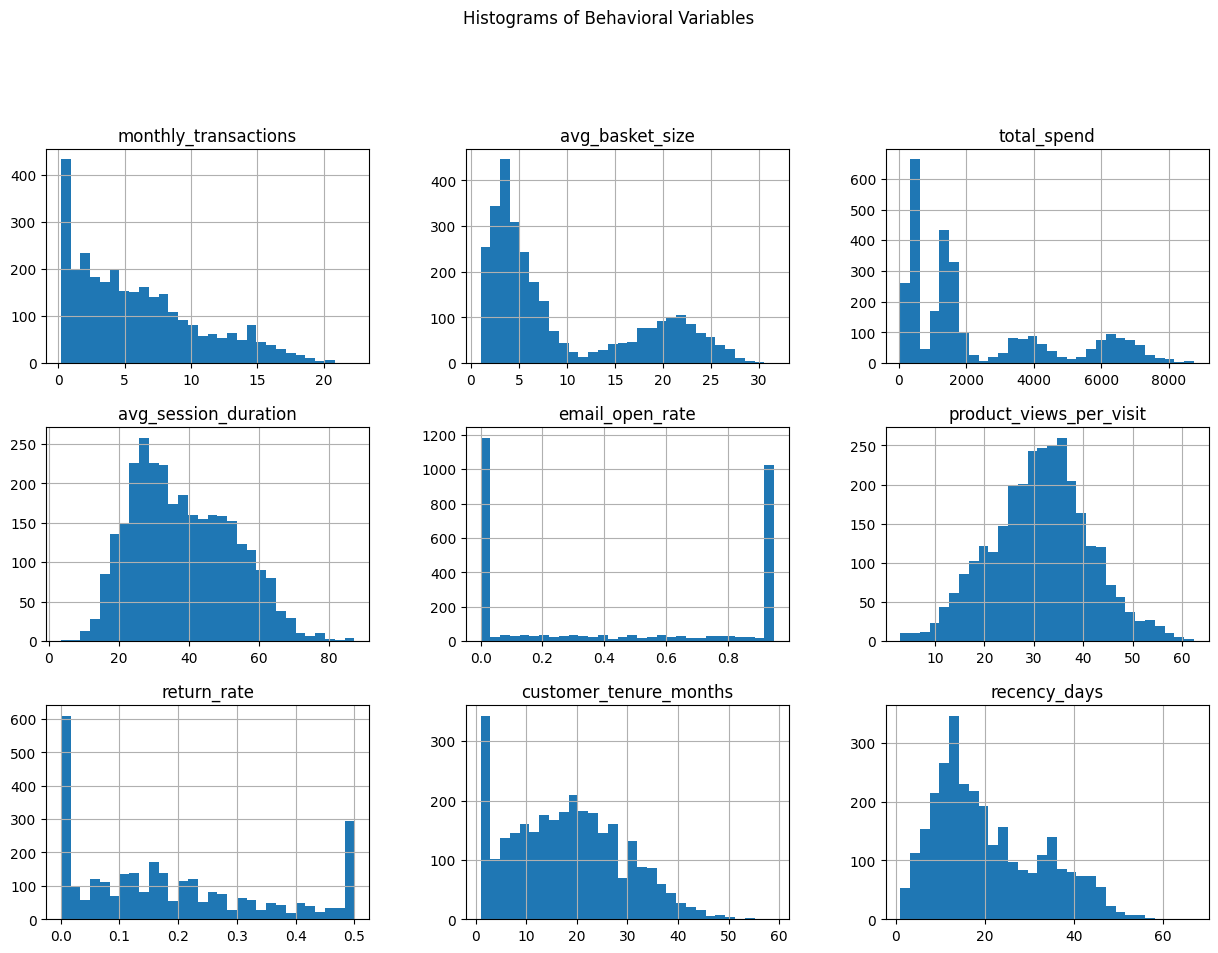

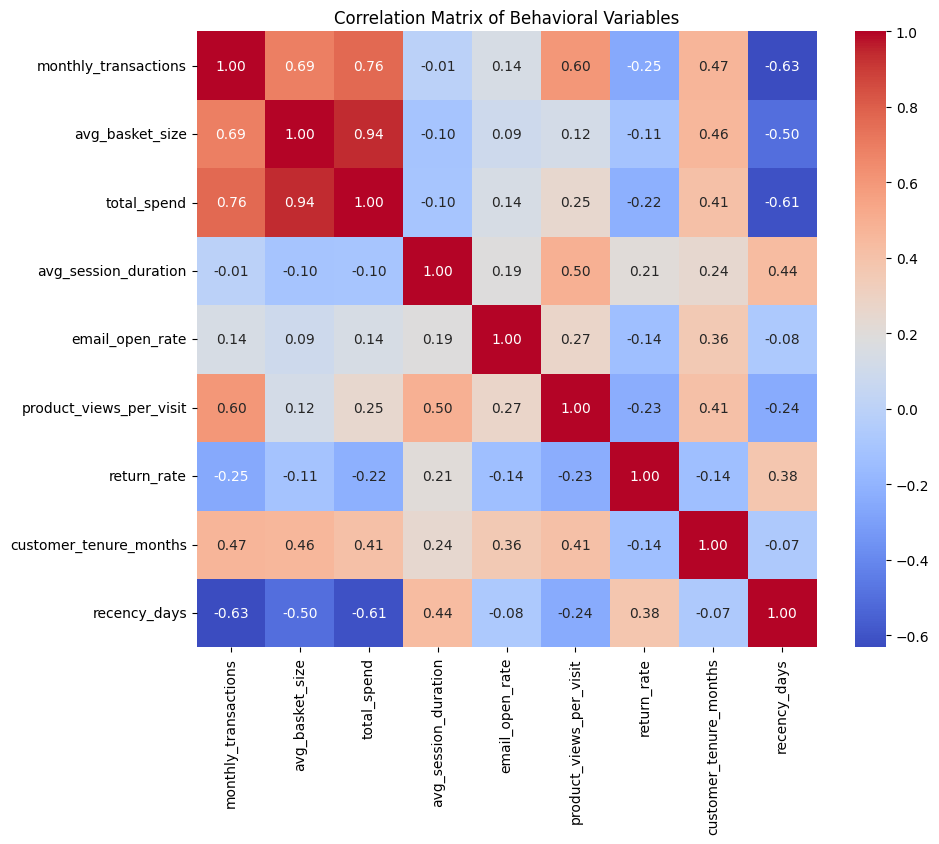

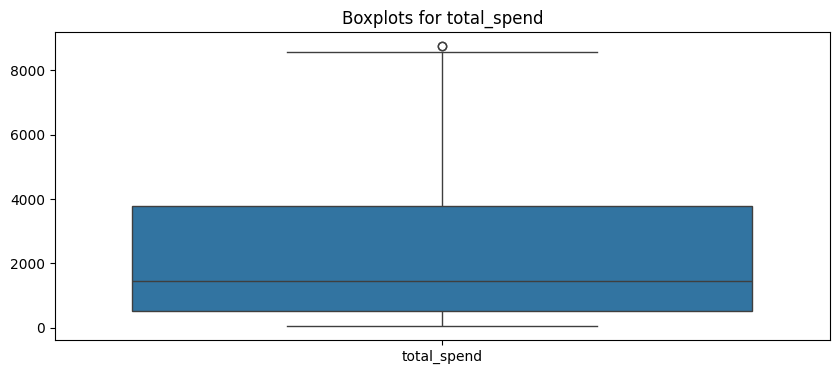

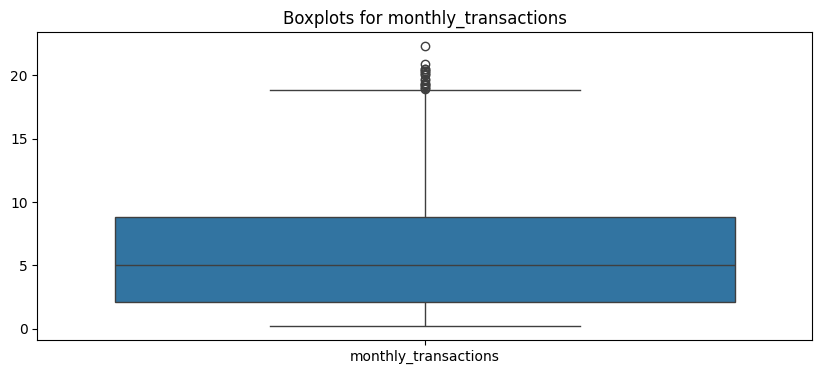

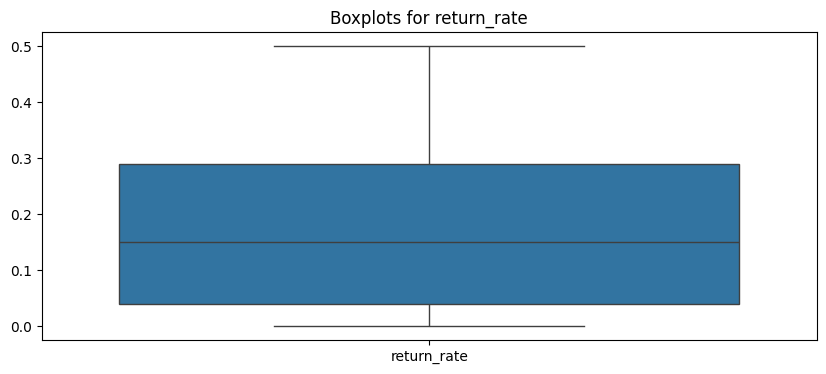

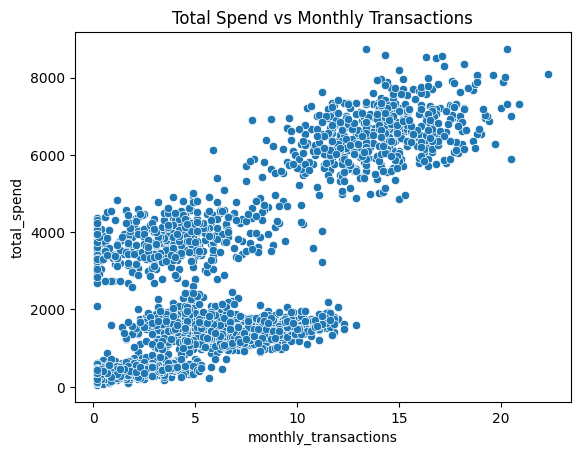

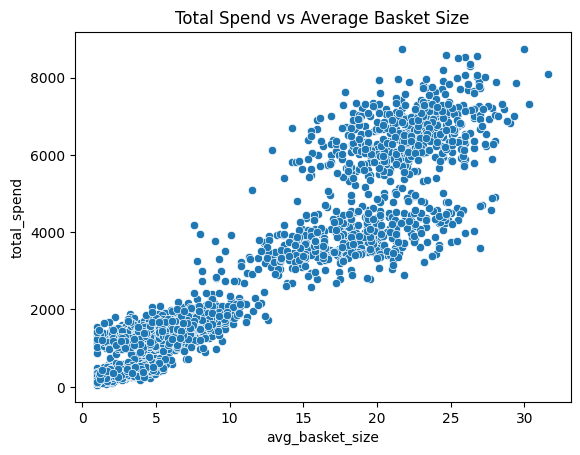

In [ ]:

# We start the numerical analysis but we exclude 'customer_id' because it isn't a behavioral variable
id_col = "customer_id"
feature_cols = [c for c in df.columns if c != id_col]
df_features = df[feature_cols]

# Histograms for each numerical variable
df_features.hist(bins=30, figsize=(15, 10))
plt.suptitle("Histograms of Behavioral Variables", y=1.02)
plt.show()

# Correlation matrix heatmap
corr = df_features.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Behavioral Variables")
plt.show()

# Boxplots for selected variables (e.g., total_spend, monthly_transactions)
plt.figure(figsize=(10, 4))
sns.boxplot(data=df_features[["total_spend"]])
plt.title("Boxplots for total_spend")
plt.show()

plt.figure(figsize=(10, 4))
sns.boxplot(data=df_features[["monthly_transactions"]])
plt.title("Boxplots for monthly_transactions")
plt.show()

plt.figure(figsize=(10, 4))
sns.boxplot(data=df_features[["return_rate"]])
plt.title("Boxplots for return_rate")
plt.show()

# Scatter plots
plt.figure()
sns.scatterplot(
    data=df,
    x="monthly_transactions",
    y="total_spend"
)
plt.title("Total Spend vs Monthly Transactions")
plt.show()

plt.figure()
sns.scatterplot(
    data=df,
    x="avg_basket_size",
    y="total_spend"
)
plt.title("Total Spend vs Average Basket Size")
plt.show()


## Section 3: Data Preprocessing

In [ ]:
# Since there are no missing values, we just do the standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features)

**Why is standardization necessary for clustering?**

It is necessary because clustering relies on distance calculations to determine similarities between the data points. These calculations can be altered when different variables use different scales since it can give a bigger or smaller weight to one variable, so it is necessary to convert the variables onto the same scale.


## Section 4: Hierarchical Clustering Analysis

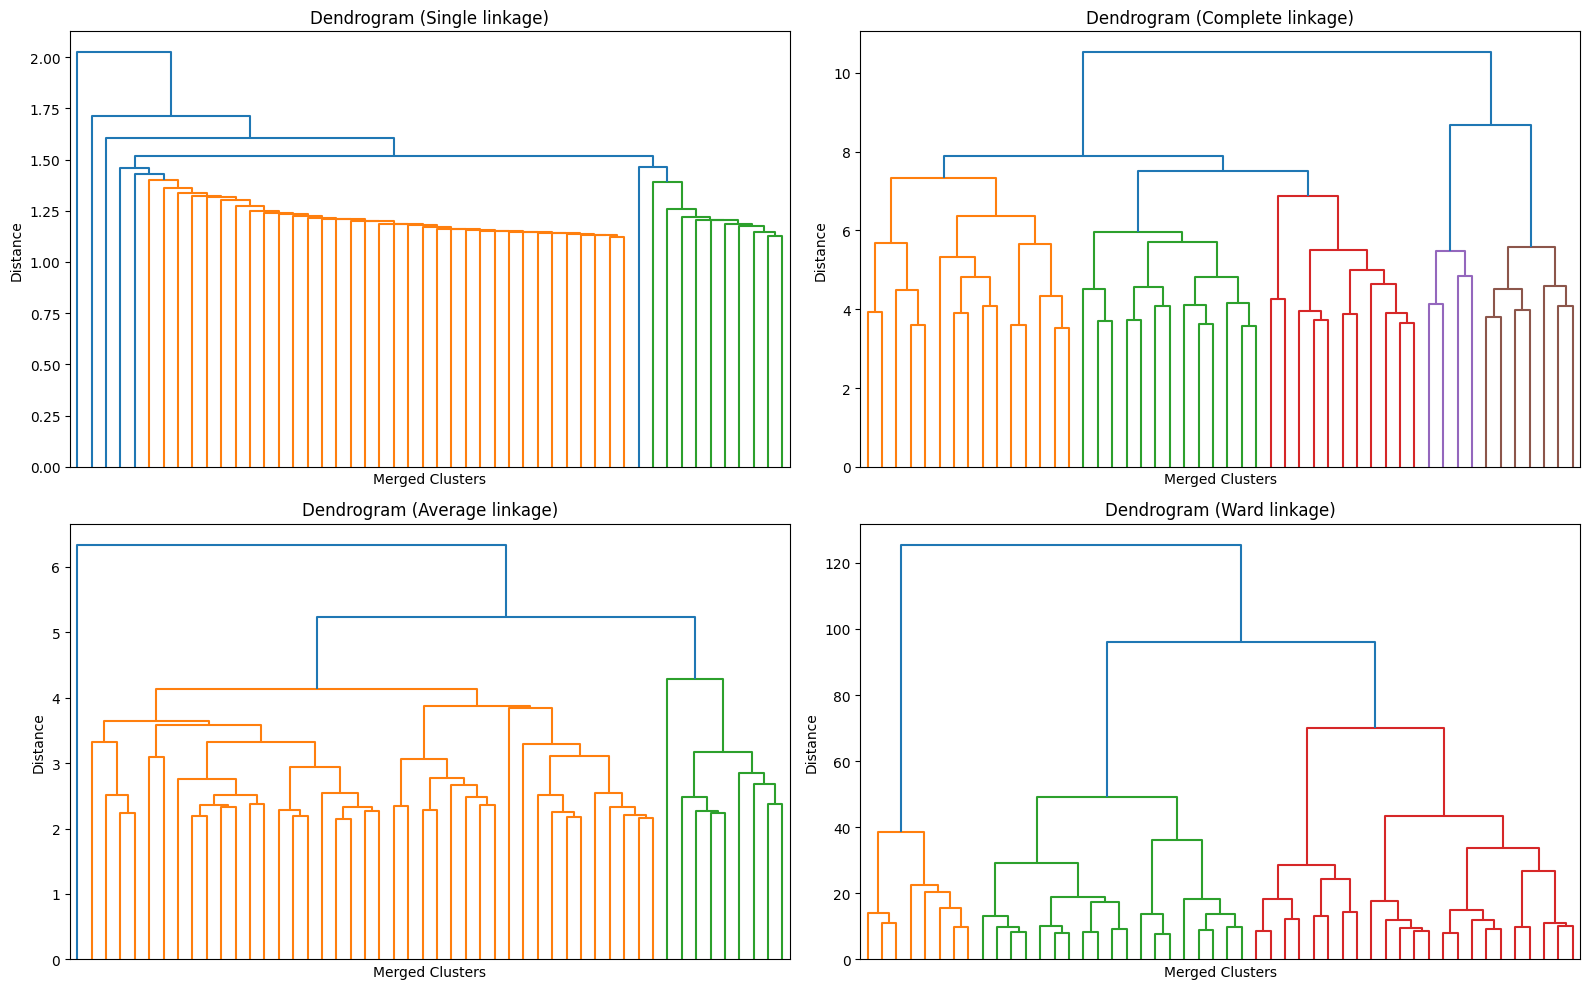

In [ ]:
# Calculation of hierarchical clustering using the four linkage methods
# Plot dendrograms for each method
linkage_methods = ["single", "complete", "average", "ward"]
Z_dict = {}

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for i, method in enumerate(linkage_methods):
    Z = linkage(X_scaled, method=method)
    Z_dict[method] = Z

    dendrogram(
        Z,
        truncate_mode="lastp",
        p=50,
        no_labels=True,
        ax=axes[i]
    )
    axes[i].set_title(f"Dendrogram ({method.capitalize()} linkage)")
    axes[i].set_xlabel("Merged Clusters")
    axes[i].set_ylabel("Distance")

plt.tight_layout()
plt.show()

**Interpretation of dendrograms**

* Which linkage method appears most suitable? (Hint: Ward's typically performs best for customer segmentation)

After visualizing the four linkage methods, we believe that ward's linkage is the best choice because it creates compact and well-separated clusters, which is more helpful when interpreting the segments.

* Where would you cut the dendrogram? What does the height of merges tell you?

For the ward's dendrogram, it would be appropiate to cut below ome of the largest vertical jump between merges, which would be around the distance 70.

* What is the "chaining effect" and which linkage method is most susceptible to it?

This effect causes elongated clusters because it prioritizes the linkage between the closest points. It is more common when using the single linkage since it uses the minimum distance between points to determine the distance. (Beyond Knowledge Innovation, 2024)


## Section 5: Determining Optimal Number of Clusters (Hierarchical)


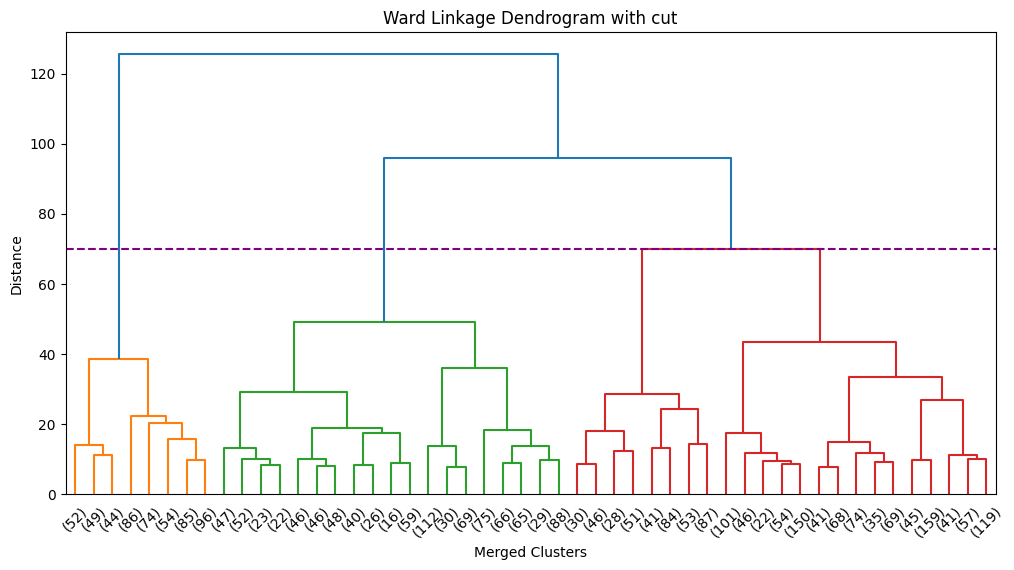

k = 3, Hierarchical Silhouette Score = 0.2948
k = 4, Hierarchical Silhouette Score = 0.3157
k = 5, Hierarchical Silhouette Score = 0.3003
k = 6, Hierarchical Silhouette Score = 0.2475


,k,silhouette_score
0,3,0.294781
1,4,0.315700
2,5,0.300267
3,6,0.247512


In [ ]:
# Ward linkage dendrogram with cut
Z_ward = Z_dict["ward"]

plt.figure(figsize=(12, 6))
dendrogram(
    Z_ward,
    truncate_mode="lastp",
    p=50,
    leaf_rotation=45.,
    leaf_font_size=10.,
)
plt.title("Ward Linkage Dendrogram with cut")
plt.xlabel("Merged Clusters")
plt.ylabel("Distance")

plt.axhline(y=70, color="purple", linestyle="--")
plt.show()


# Silhouette scores for different k
hier_silhouette_scores = OrderedDict()
candidate_ks = [3, 4, 5, 6]

for k in candidate_ks:
    labels_hc = fcluster(Z_ward, t=k, criterion="maxclust")
    score = silhouette_score(X_scaled, labels_hc)
    hier_silhouette_scores[k] = score
    print(f"k = {k}, Hierarchical Silhouette Score = {score:.4f}")

# Table
hier_silhouette_df = pd.DataFrame({
    "k": list(hier_silhouette_scores.keys()),
    "silhouette_score": list(hier_silhouette_scores.values())
})
display(hier_silhouette_df)


## Section 6: K-Means Clustering - Elbow Method

k = 2, Inertia = 19065.45, Silhouette = 0.3446
k = 3, Inertia = 14397.53, Silhouette = 0.2974
k = 4, Inertia = 11944.28, Silhouette = 0.3173
k = 5, Inertia = 10616.55, Silhouette = 0.2696
k = 6, Inertia = 9517.15, Silhouette = 0.2791
k = 7, Inertia = 8736.43, Silhouette = 0.2815
k = 8, Inertia = 7999.74, Silhouette = 0.2784
k = 9, Inertia = 7454.65, Silhouette = 0.2662
k = 10, Inertia = 6981.05, Silhouette = 0.2708


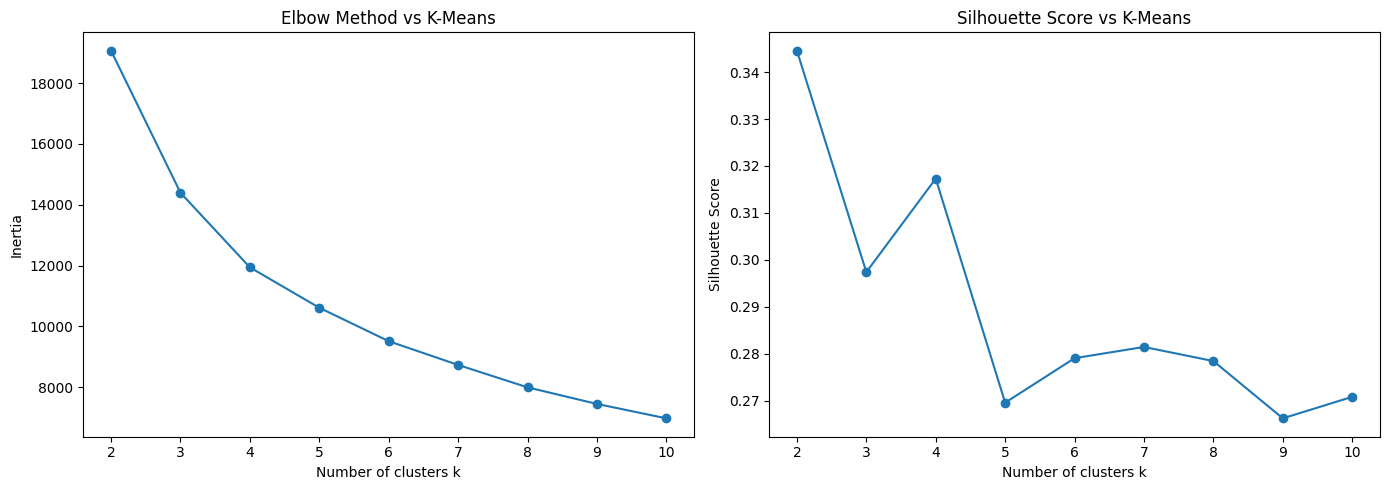

In [ ]:
# Inertia Calculation for each k=2-10
k_values = range(2, 11)
inertias = []
kmeans_silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)

    inertias.append(kmeans.inertia_)

    labels_km = kmeans.labels_
    sil_score = silhouette_score(X_scaled, labels_km)
    kmeans_silhouette_scores.append(sil_score)
    print(f"k = {k}, Inertia = {kmeans.inertia_:.2f}, Silhouette = {sil_score:.4f}")

# Elbow and Silhouette scores plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow plot
axes[0].plot(list(k_values), inertias, marker="o")
axes[0].set_title("Elbow Method vs K-Means")
axes[0].set_xlabel("Number of clusters k")
axes[0].set_ylabel("Inertia")

# Silhouette plot
axes[1].plot(list(k_values), kmeans_silhouette_scores, marker="o")
axes[1].set_title("Silhouette Score vs K-Means")
axes[1].set_xlabel("Number of clusters k")
axes[1].set_ylabel("Silhouette Score")

plt.tight_layout()
plt.show()

* Where does the elbow occur?

On the plot, there are two big drops, from 2 to 3 and from 3 to 4, and after 4 the curve starts to flatten. This means that the albow is around 4.

* Does the silhouette score agree?

For the silhouette, the best 2 scores are for 2 and 4, 2 being the best. Even if 2 is the global optimum, 4 is a strong local peak so it supports the elbow.

## Section 7: Final Cluster Selection


* Optimal K

Based on our analysis, the most suitable and optimal k would be 4.

* Justifying our choice

We base our choice on the diverse evidence we collected through the analysis. Firstly, the ward dendrogram shows 4 perfectly identifiable groups after the cut. Secondly, the elbow shows that adding more clusters after 4 only gives a small margin of gains. Finally, the silhouette score shows that even though the global optimal is 2, 4 clusters also representas a local optimal.



## Section 8: Apply Final K-Means Model


In [ ]:
k_final = 4

kmeans_final = KMeans(n_clusters=k_final, random_state=42, n_init=10)
kmeans_final.fit(X_scaled)

cluster_labels = kmeans_final.labels_
df["cluster_kmeans"] = cluster_labels

# Cluster sizes
cluster_counts = df["cluster_kmeans"].value_counts().sort_index()
cluster_percentages = (cluster_counts / len(df) * 100).round(2)

cluster_summary = pd.DataFrame({
    "cluster": cluster_counts.index,
    "count": cluster_counts.values,
    "percentage": cluster_percentages.values
})

print("Cluster size and percentage:")
display(cluster_summary)


Cluster size and percentage:


,cluster,count,percentage
0,0,525,17.50
1,1,929,30.97
2,2,433,14.43
3,3,1113,37.10


## Section 9: Cluster Profiling and Interpretation

Cluster means with original scale:


cluster_kmeans,0,1,2,3
monthly_transactions,14.073524,1.683100,4.042494,6.586972
avg_basket_size,22.025714,3.050161,18.173903,5.560647
total_spend,6507.290648,422.620377,3875.935543,1450.947125
avg_session_duration,45.918095,52.308719,22.359122,29.596855
email_open_rate,0.576210,0.374166,0.449538,0.437017
product_views_per_visit,43.008571,30.014532,16.548499,32.749236
return_rate,0.098990,0.274672,0.244804,0.129856
customer_tenure_months,26.220952,15.305705,21.602771,14.734052
recency_days,8.024762,35.592034,19.840647,14.530997


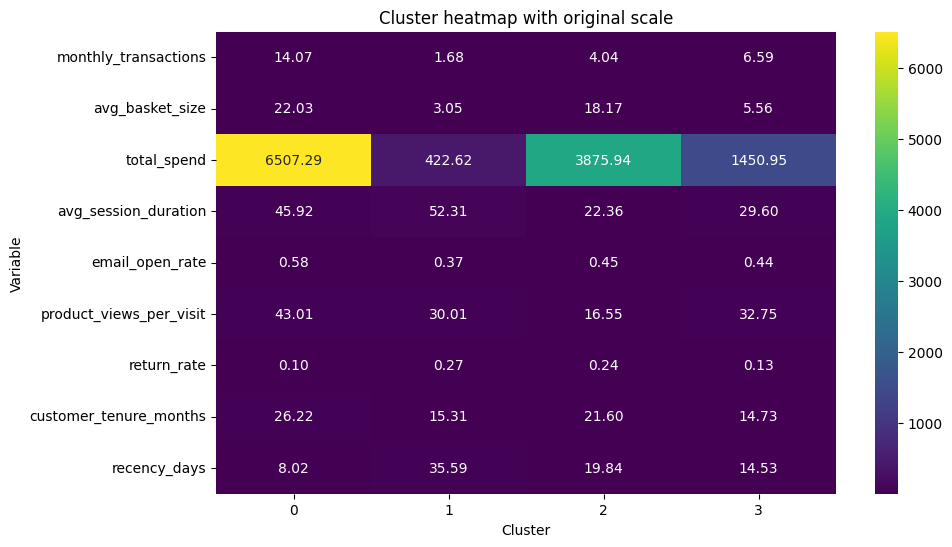


Cluster means normalized:


cluster_kmeans,0,1,2,3
monthly_transactions,1.607210,-1.056159,-0.548998,-0.002053
avg_basket_size,1.218330,-1.135150,0.740602,-0.823782
total_spend,1.465003,-1.123966,0.345386,-0.686423
avg_session_duration,0.694178,1.224041,-1.259159,-0.659060
email_open_rate,1.595274,-1.160100,-0.132209,-0.302965
product_views_per_visit,1.316705,-0.059930,-1.486570,0.229794
return_rate,-1.186764,1.180043,0.777656,-0.770935
customer_tenure_months,1.424931,-0.877554,0.450762,-0.998140
recency_days,-1.125712,1.579297,0.033709,-0.487295


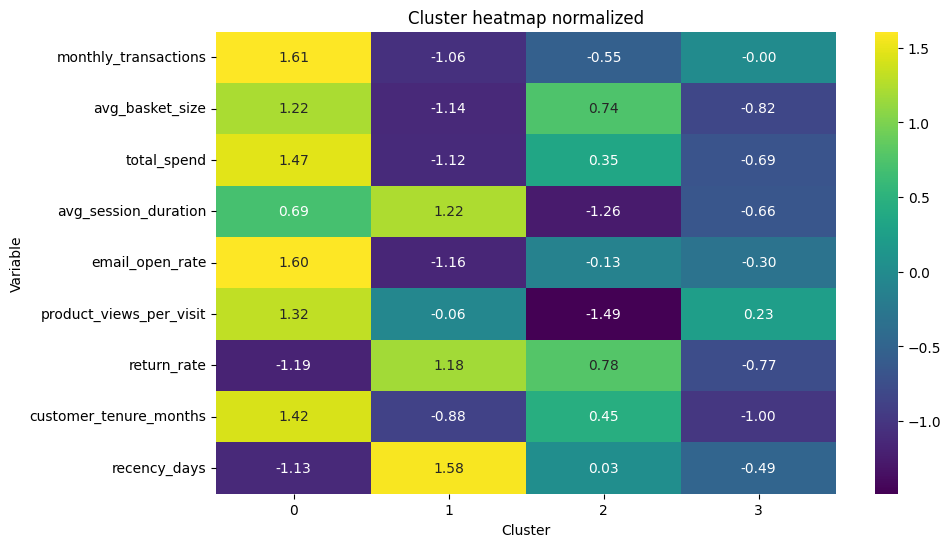

In [ ]:
# Cluster means with original scale
cluster_profile = df.groupby("cluster_kmeans")[feature_cols].mean().T
print("Cluster means with original scale:")
display(cluster_profile)

# Heatmap with original scale
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_profile, annot=True, fmt=".2f", cmap="viridis")
plt.title("Cluster heatmap with original scale")
plt.xlabel("Cluster")
plt.ylabel("Variable")
plt.show()

# Cluster means with normalized scale
cluster_profile_norm = cluster_profile.copy()

cluster_profile_norm = (
    cluster_profile_norm
    .sub(cluster_profile_norm.mean(axis=1), axis=0)
    .div(cluster_profile_norm.std(axis=1, ddof=0), axis=0)
)

print("\nCluster means normalized:")
display(cluster_profile_norm)

# Heatmap with normalized clusters
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_profile_norm, annot=True, fmt=".2f", cmap="viridis")
plt.title("Cluster heatmap normalized")
plt.xlabel("Cluster")
plt.ylabel("Variable")
plt.show()


**Characterization**
* Cluster 0 (17.50%)

Very high monthly transactions, basket size, total spend, email open rate, product views and tenure. Very unlikely to return or have a high tenure. These type of clients are the most engaged ones and should be prioritized.

* Cluster 1 (30.97%)

Very low spend, frequency, basket size, and email engagement, but long session duration, high recency, and the highest return rate. They seem to browse a lot, buy little, and return often. This could mean curiosity on the products but not enough incentives to buy like clear information or costumized service.

* Cluster 2 (14.43%)

Low transaction frequency but large basket size and normal total spend, with moderate tenure and positive but positive return rate. It seems like they don’t visit often, but when they do, they make considerable purchases: This could mean they get attracted by seasonal offers or campaigns.

* Cluster 3 (37.10%)

The largest set of clients. Average transaction frequency, small basket size, below-average total spend and engagement, and short tenure, with low return rate. These seem to be "passers-by" who may be new customers and are starting to know the products.

## Section 10: Cluster Validation - Silhouette Analysis

Average silhouette score for k = 4: 0.3173


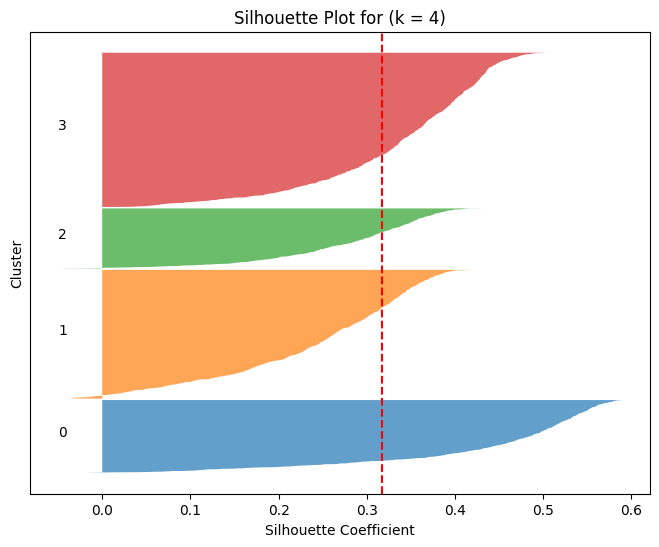

In [ ]:
# Standardized data and the labels from our final model
X = X_scaled
cluster_labels = kmeans_final.labels_
n_clusters = k_final

# Average silhouette score
silhouette_avg = silhouette_score(X, cluster_labels)
print(f"Average silhouette score for k = {n_clusters}: {silhouette_avg:.4f}")

# Silhouette values per sample
sample_silhouette_values = silhouette_samples(X, cluster_labels)

# Silhouette plot
y_lower = 10
fig, ax = plt.subplots(figsize=(8, 6))

for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        alpha=0.7
    )

    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

ax.axvline(x=silhouette_avg, color="red", linestyle="--")
ax.set_title(f"Silhouette Plot for (k = {n_clusters})")
ax.set_xlabel("Silhouette Coefficient")
ax.set_ylabel("Cluster")
ax.set_yticks([])
plt.show()

**Discussion**

* Which clusters are well-defined (high silhouette values)?

Clusters 0 and 3 look the best defined since their silhouettes are clearly above the average line and a alrge part od the points are around 0.4 and 0.6, meaning that the clusters are clealry defined and those customers are not close to being from another cluster.

* Are there any customers poorly matched to their cluster (negative silhouette)?

For clusters 1 and 2 a small negative silhouette can be seen, therefore there are a few customers mis-assigned to their clusters.

* Does this validate your choice of k?

Yes, a plot that shows barely any negative silhouette and has 2 strong clusters out of 4 with high positive points is a sign of a good clustering.

## Section 11: Cluster Visualization (PCA Projection)

Variance explained by PC1 and PC2: 0.6198
PC1: 0.4101, PC2: 0.2097


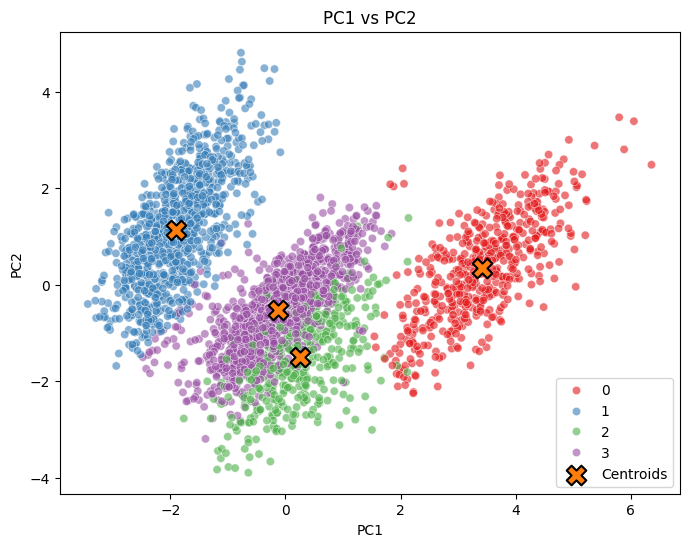

In [ ]:
# PCA using standardized data
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Explained variance
explained_var = pca.explained_variance_ratio_
print(f"Variance explained by PC1 and PC2: {explained_var.sum():.4f}")
print(f"PC1: {explained_var[0]:.4f}, PC2: {explained_var[1]:.4f}")

# Transform K-Means centroids to PCA space
centroids = kmeans_final.cluster_centers_
centroids_pca = pca.transform(centroids)

# Scatter PCA plot of customers
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=kmeans_final.labels_,
    palette="Set1",
    alpha=0.6
)

# Plot centroids
plt.scatter(
    centroids_pca[:, 0],
    centroids_pca[:, 1],
    s=200,
    marker="X",
    edgecolor="black",
    linewidth=1.5,
    label="Centroids"
)

plt.title("PC1 vs PC2")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

**Note:** This scatterplot is a 2D PCA projection of the 9-dimensional space. It is useful for visualization, but the actual clusters are formed in the full 9-dimensional space, so the separation seen here is an approximation

## Section 12: Technical Conclusion


**Optimal number of clusters and justification**

After all of the analysis, we concluded that the optimal number of clusters for this MegaMart customer segmentation is 4. This result as confirmed by various results. In the case of the Hierarchical dendrogram, the cutting showed that there are 24 very identifiable clusters. On the other hand, silhouette showed with its scores that k=2 or k=4 could be adecuate but k=4 was confirmed by k-means elbow's inertia that indicated that after k=4 the clusters give small marginal gains, something that doesn't happen with k=2.

**Hierarchical vs K-means comparison**

Hierarchical (Ward) was used mainly to explore the structure and see a range of possibilities for k. On the other hand, k-means  provides clean centroid-based segments that are easy to interpret and deploy.

**Quality metrics (silhouette scores)**

k=2 showed the highest score (0.345) but k=4 showed a similar score (0.317), better than k=3 or 5. The silhouette plot for k=4 shows mostly positive values and indicating reasonably well-separated clusters, and also indicating the correcto solution of clustering.

**Key characteristics of each discovered segment**

* Cluster 0: Very high spend, frequency, engagement, low returns, long tenure.

Cluster 1: Low spend and engagement, long sessions, high returns and recency.

Cluster 2: Low frequency but large baskets and high total spend.

Cluster 3: Moderate frequency, small baskets, low spend but low returns and relatively new customers.

## Section 13: References
* Beyond Knowledge Innovation. (2024, March 15). Single linkage hierarchical clustering. https://beyondknowledgeinnovation.ai/single-linkage-hierarchical-clustering/